In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np


In [3]:
data1 = sitk.ReadImage('../../MRI_Crohns/A/A1 Axial T2')
data2 = sitk.ReadImage('../../MRI_Crohns/A/A2 Axial T2')
# data3 = sitk.ReadImage('Abnormal/A3 Coronal T2')
data4 = sitk.ReadImage('../../MRI_Crohns/A/A4 Axial T2.nii')
data5 = sitk.ReadImage('../../MRI_Crohns/A/A5 Axial T2.nii')
data6 = sitk.ReadImage('../../MRI_Crohns/A/A6 Axial T2.nii')
data7 = sitk.ReadImage('../../MRI_Crohns/A/A7 Axial T2.nii')
# data8 = sitk.ReadImage('Abnormal/merged_A23.nii')

data = [data1, data2, data4, data5, data6, data7]

int16
int16
int16
int16
int16
int16


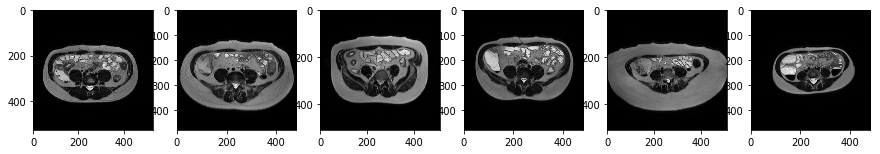

In [7]:
def show_data(data, sl):
    fig = plt.figure(figsize=(18, 18))
    fig.set_size_inches(15, 10)
    columns = len(data)
    rows = 1
    for i in range(columns):
        fig.add_subplot(rows, columns, i + 1)
        nda = sitk.GetArrayFromImage(data[i])
        print(nda.dtype)
        nda = nda.astype(np.float32)

        plt.imshow(nda[sl], cmap='gray')
    plt.show()
    
show_data(data, 30)

(264, 264, 36)
int16


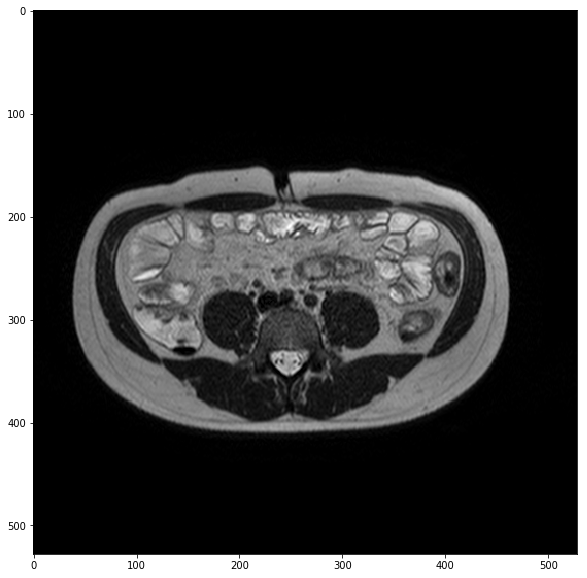

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


int16


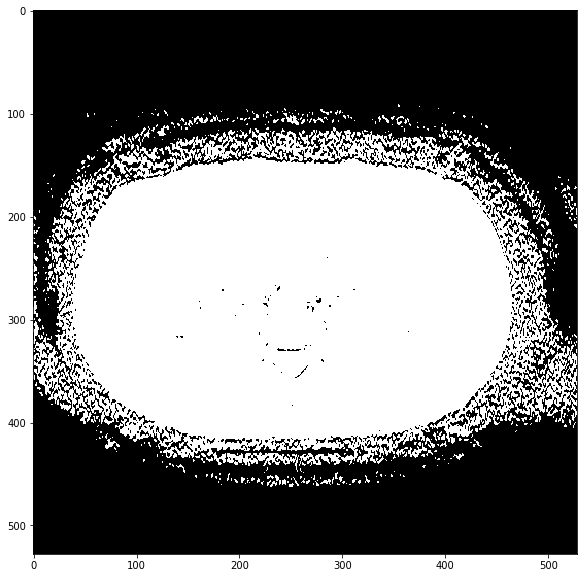

(240, 240, 36)
int16


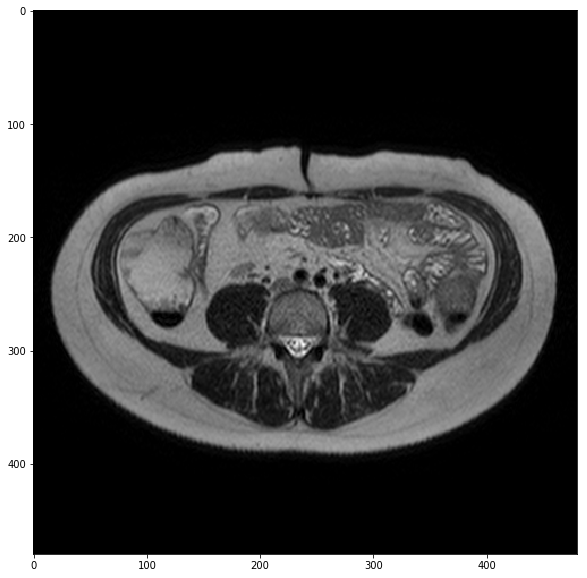

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


int16


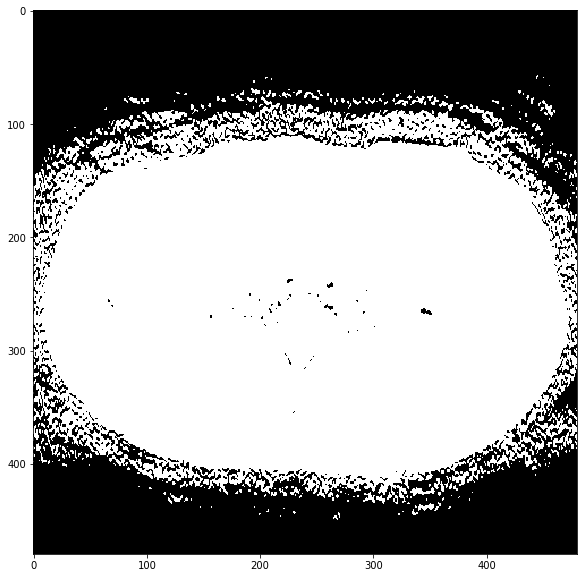

(256, 256, 45)
int16


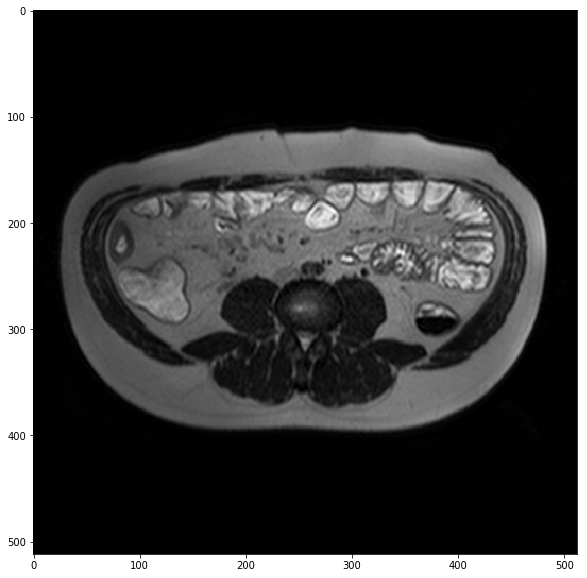

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


int16


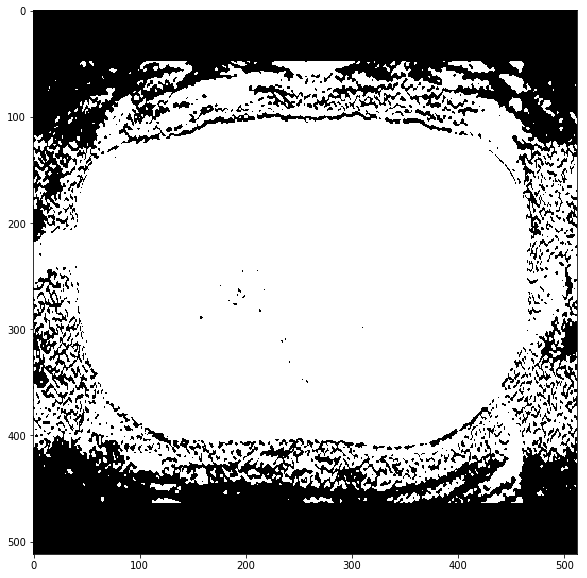

(240, 240, 36)
int16


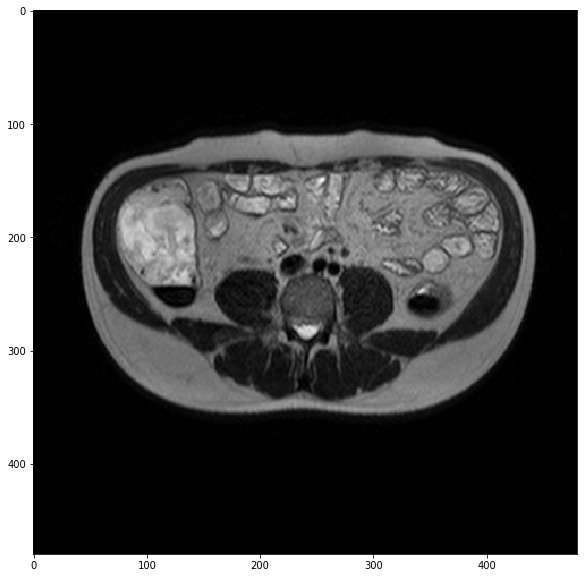

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


int16


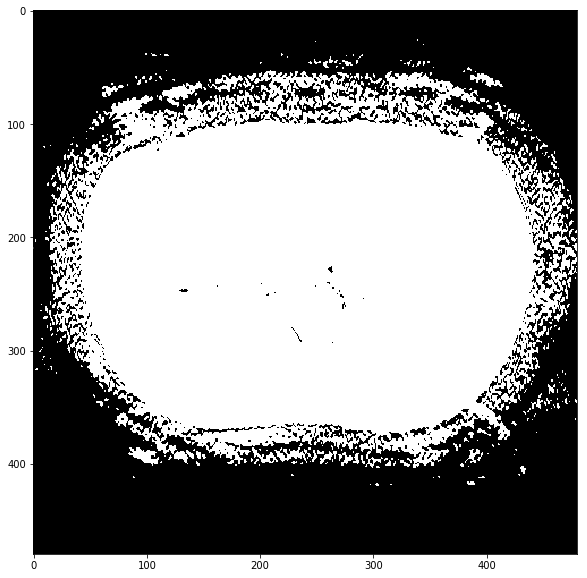

(256, 256, 42)
int16


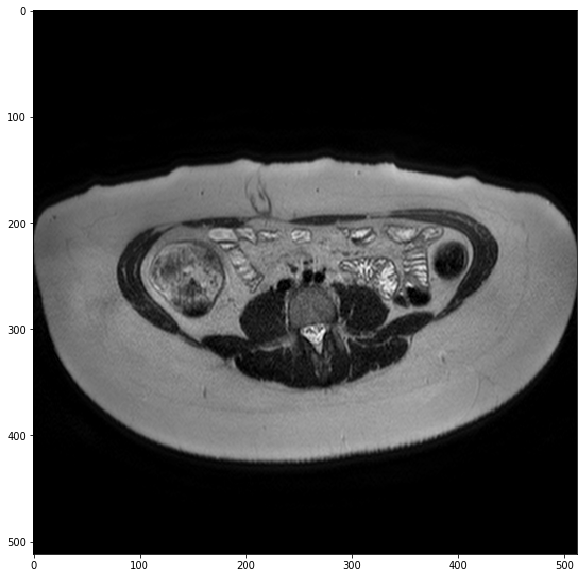

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


int16


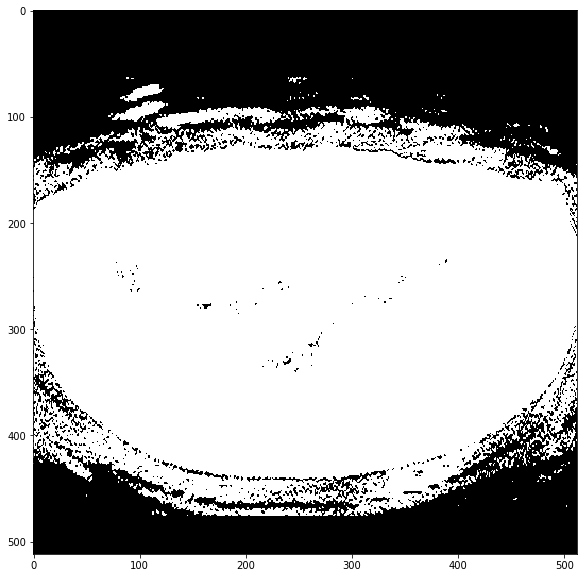

(240, 240, 36)
int16


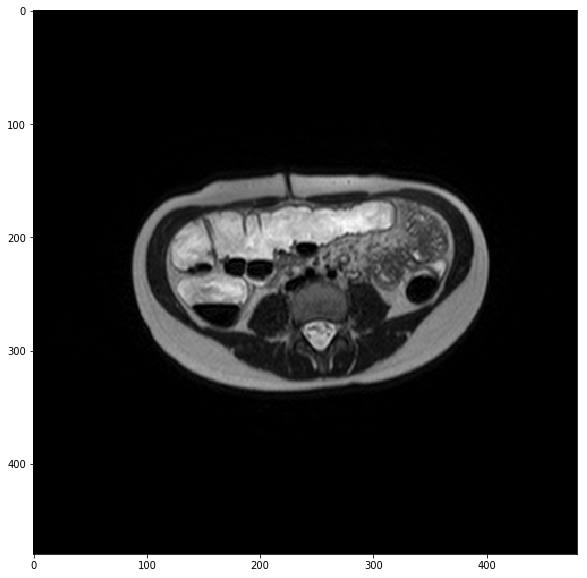

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


int16


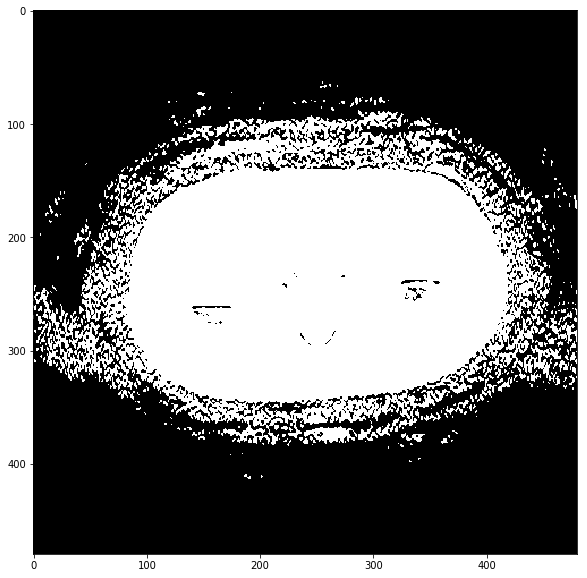

In [9]:
def threshold_based_crop(image):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 20
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    center = (int(image.GetSize()[0]/2), int(image.GetSize()[1]/2), int(image.GetSize()[2]/2))
    center2 = (int(image.GetSize()[0]/2), int(image.GetSize()[1]/2), int(image.GetSize()[2]/2) - 5)
    center3 = (int(image.GetSize()[0]/2), int(image.GetSize()[1]/2), int(image.GetSize()[2]/2) + 5)

#     center = (0, 0, 0)
    print(center)
    
    seg = sitk.Image(image.GetSize(), sitk.sitkUInt8)
    seg.CopyInformation(image)
    seg[center] = 1

    seg = sitk.BinaryDilate(seg, 3)

    show_data([sitk.LabelOverlay(image, seg)], center[2])
    
    
    seg_explicit_thresholds = sitk.ConnectedThreshold(image, seedList=[center, center2, center3], 
                                                      lower=inside_value, upper=outside_value)
    overlay = sitk.LabelOverlay(image, seg_explicit_thresholds)
    show_data([overlay], 30)
    label_shape_filter.Execute( seg_explicit_thresholds )
    bounding_box = label_shape_filter.GetBoundingBox(1)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])
    

modified_data = [threshold_based_crop(img) for img in data]

int16


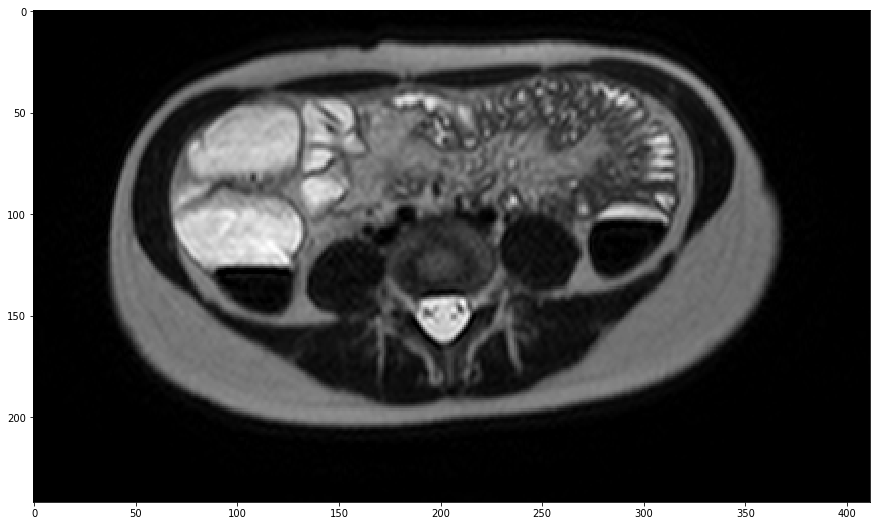

In [11]:
show_data([modified_data[5]], 30)

In [162]:
dimension = modified_data[0].GetDimension()

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)
for img in modified_data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]

# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()
reference_size = [256, 128, 64] # Arbitrary sizes, smallest size that yields desired results. 
reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

reference_image = sitk.Image(reference_size, modified_data[0].GetPixelIDValue())
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

# Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as 
# this takes into account size, spacing and direction cosines. For the vast majority of images the direction 
# cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the 
# spacing will not yield the correct coordinates resulting in a long debugging session. 
reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [163]:
resampled_data = []
for img in modified_data:
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.TranslationTransform(dimension)
#     transform.SetMatrix(img.GetDirection())
    transform.SetOffset(np.array(img.GetOrigin()) - reference_origin)
    
    centering_transform = sitk.TranslationTransform(dimension)
    centered_transform = sitk.Transform(transform)
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))    
    centered_transform.AddTransform(centering_transform)
    
    # Using the linear interpolator as these are intensity images
    resampled_data.append(sitk.Resample(img, reference_image, centered_transform, sitk.sitkLinear, 0.0))

In [164]:
# MERGE UPPER AND LOWER IMAGES
def merge_images(img_A, img_B):
    # Transform which maps from the reference_image to the current img with the translation mapping the image
    # origins to each other.
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img_A.GetDirection())
    
    diff = numpy.linalg.norm(np.array(img_A.GetOrigin()) - np.array(img_B.GetOrigin()))
    half_box = (img_A.GetSize()[2] * img_A.GetSpacing()[2] + img_B.GetSize()[2] * img_B.GetSpacing()[2])/2
    n_pixels_remove = math.ceil((half_box - diff) / img_A.GetSpacing()[2])
    pixels_remove_A = n_pixels_remove // 2
    pixels_remove_B = n_pixels_remove - pixels_remove_A
    print(n_pixels_remove)
    print(pixels_remove_B)
    
    array = sitk.GetArrayFromImage(img_A)
    print(array.shape)
    array[0:n_pixels_remove] = np.zeros((n_pixels_remove, img_A.GetSize()[1], img_A.GetSize()[0]))
    print(array.shape)
    img_A_new = sitk.GetImageFromArray(array)
    img_A_new.SetSpacing(img_A.GetSpacing())
    img_A_new.SetOrigin(img_A.GetOrigin())
    img_A_new.SetDirection(img_A.GetDirection())
    
#     shrunk_A = sitk.RegionOfInterest(img_A, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])

    
    transform.SetTranslation(np.array(img_A_new.GetOrigin()) - reference_origin)

    centering_transform = sitk.TranslationTransform(dimension)
    centered_transform = sitk.Transform(transform)

    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    img_center = np.array(img_A_new.TransformContinuousIndexToPhysicalPoint(np.array(img_A_new.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))    
    centered_transform.AddTransform(centering_transform)

    # Using the linear interpolator as these are intensity images
    img1 = sitk.Resample(img_A_new, reference_image, centered_transform, sitk.sitkLinear, 0.0)
    img2 = sitk.Resample(img_B,reference_image, centered_transform, sitk.sitkLinear, 0.0)
    return img1 + img2
    
# resampled_data.append(merge_images(modified_data[3], modified_data[4]))
# resampled_data.append(merge_images(modified_data[5], modified_data[6]))

int16
neck
int16
neck
int16
neck
int16
neck
int16
neck
int16
neck


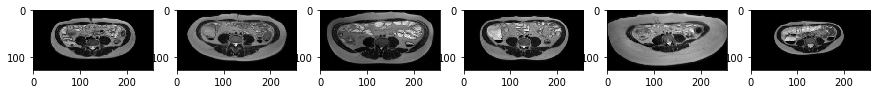

In [166]:
show_data(resampled_data, 30)

In [31]:
def save_image(image, name):
    sitk.WriteImage(image, os.path.join('/Users/Robert/Documents/IC/Final_Year_Project/Abnormal', name))
    
# save_image(resampled_data[3], 'merged_A14.nii')
# save_image(resampled_data[4], 'merged_A23.nii')

In [102]:
from dltk.io.augmentation import *
import numpy as np
import cv2
import scipy
# from dltk.io.preprocessing import *

class Augmentor:
    def __init__(self):
        self.angle_std = 5
        self.alpha, self.sigma = 6e3, 25

    def random_rotate(self, image):
        angle = np.random.normal(loc=0, scale=self.angle_std)
        angle = 7
        return scipy.ndimage.interpolation.rotate(image, angle, axes=(1, 2), reshape=False, order=5, mode='nearest')

    def augment_batch(self, images):
        for i in range(len(images)):
            images[i] = self.augment(images[i])
        return images

    def augment(self, image):
        image = flip(image, axis=2)
        image = self.random_rotate(image)
#         image = add_gaussian_noise(image, sigma=0.005)
#         image = elastic_transform(image, alpha=[self.alpha, self.alpha, self.alpha],
#                                              sigma=[self.sigma ,self.sigma, self.sigma])
        return image
    
augmentor = Augmentor()

In [ ]:
arrays = [sitk.GetArrayFromImage(image) for image in resampled_data]
augmented = augmentor.augment_batch(arrays)

In [ ]:
augmented_images = [sitk.GetImageFromArray(array) for array in augmented]
show_data(augmented_images, 35)

In [ ]:
save_image(augmented_images[2], 'rotated.nii')
save_image(resampled_data[2], 'unrotated.nii')